## QBUS3850 Tutorial 10: Asymmetric GARCH, Volatility forecasting


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
import statsmodels.api as sm
from scipy import stats

### The dataset BHP00-20.csv contains daily prices on BHP stock from 2000-01-04 to 2020-04-06. First, use an in-sample period of all but the final 125 return observations.

In [14]:
BHPdata = pd.read_csv('BHP00-20.csv', parse_dates=['Date'], dayfirst = True)
## Remove some public holidays that have crept into the data.
BHPdata = BHPdata[ BHPdata['Adj Close'] > 0 ]
print( BHPdata.tail() )

BHPdates = BHPdata['Date']
BHPprices = BHPdata['Adj Close']

## Compute log-returns.
BHPr = ( 100 * ( np.log( BHPprices ) - np.log( BHPprices.shift() ) ) )[1:]
assert( np.isnan( BHPr ).sum() == 0 )

n = len(BHPr) #Total sample size
nis = len(BHPr) - 125 #In-sample size
BHPris = BHPr[:nis] #Select in-sample returns
BHPrf = BHPr[nis:] #Forecast sample returns
nf = len(BHPrf) #Forecast sample size
assert( nf == 125 )

           Date       Open       High        Low  Close  Adj Close      Volume
5157 2020-03-31  30.330000  30.480000  28.450001  28.98      28.98  14599950.0
5158 2020-04-01  29.950001  30.629999  29.650000  30.23      30.23  12416279.0
5159 2020-04-02  29.500000  30.059999  29.260000  29.85      29.85   8658031.0
5160 2020-04-03  31.120001  31.350000  30.000000  30.33      30.33  10409253.0
5161 2020-04-06  30.700001  31.290001  30.549999  30.98      30.98   2505959.0


### Q1(a) Use the AIC, SIC to choose an AR(1)-GARCH(p,q) with Gaussian or Student-t errors. Fit this model and assess its fit to the data.

Text(0.5, 1.0, 'Log Returns')

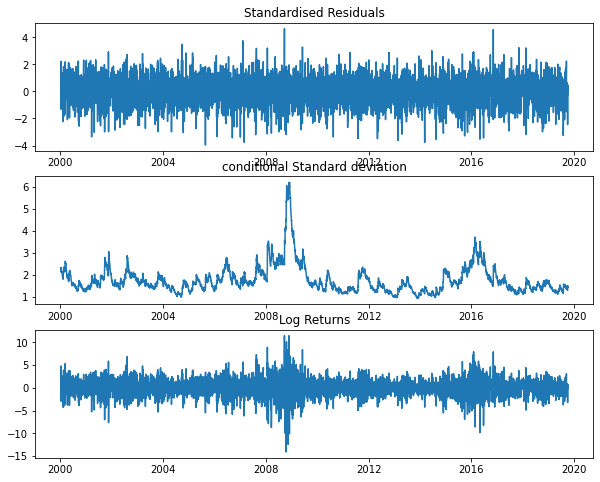

In [25]:
## This was done in QBUS3850 Lab 9.
## SIC chooses a constant mean GARCH(1,1) with t-errors.
## Estimate chosen model 

#TODO model training 
Mdl = arch_model (BHPris, mean='Constant', vol='GARCH', p=1, q=1, dist='studentst')
EstMdl = Mdl.fit(disp='off')

s = EstMdl.conditional_volatility # conditional standard deviation
v = s**2 # conditional variance
a = BHPris - EstMdl.params['mu'] # innovations
e = a/s #stadardized residuals








#TODO Plot the standardized residuals, conditional standard deviations and log returns above one another


fig, axs = plt.subplots(3, 1, figsize=(10, 8))
axs[0].plot(BHPdates[1:nis+1], e)
axs[0].set_title('Standardised Residuals')

axs[1].plot(BHPdates[1:nis+1], s)
axs[1].set_title('conditional Standard deviation')


axs[2].plot(BHPdates[1:nis+1], BHPris)
axs[2].set_title('Log Returns')


In [59]:
arch_model?

### Q1(b): Add a GJR lag 1 term to the volatility equation of the model chosen in part (a). Estimate the model and assess its fit to the data.

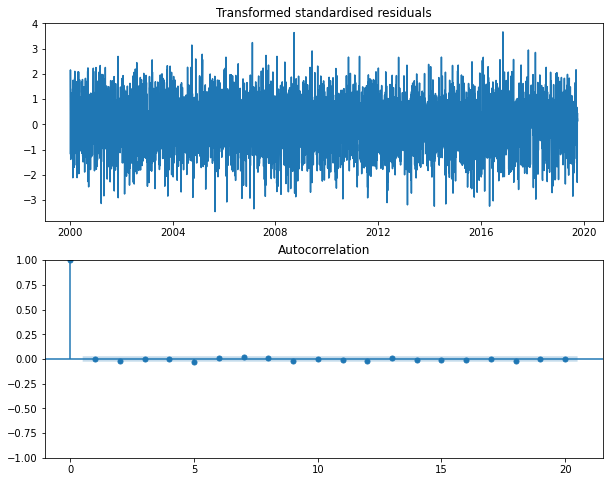

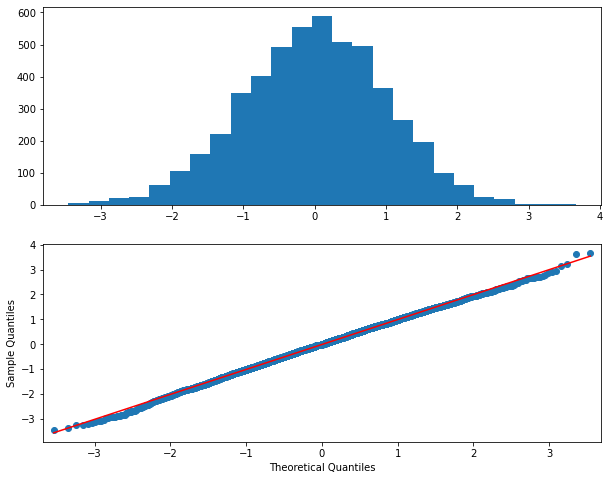

In [57]:
## Fit GJR-GARCH(1,1)-t model as chosen by SIC

# TODO model training
Mdl = arch_model (BHPris, mean='Constant', vol='GARCH', p=1, q=1, o=1, dist='studentst')
EstMdl = Mdl.fit(disp='off')

s = EstMdl.conditional_volatility # conditional standard deviation
v = s**2 # conditional variance
a = BHPris - EstMdl.params['mu'] # innovations
e = a/s #stadardized residuals

nu = EstMdl.params['nu']


# TODO Plot the standardized residuals, conditional standard deviations and log returns above one another


# transform back to normal error
ge =stats.norm.ppf(stats.t.cdf(np.sqrt(nu) / np.sqrt(nu-2) * e, nu))


fig, axs = plt.subplots(2, 1, figsize=(10, 8))
axs[0].plot(BHPdates[1:nis+1], ge)
axs[0].set_title('Transformed standardised residuals')
sm.graphics.tsa.plot_acf(ge, ax=axs[1], lags=20)

fig, axs = plt.subplots(2, 1, figsize=(10, 8))
axs[0].hist(ge, bins=25)
sm.qqplot(ge, ax=axs[1], line='r')

aGJt=a
sigGJT=s

None

### Q1(c) Draw and discuss the two news impact curves from this model.

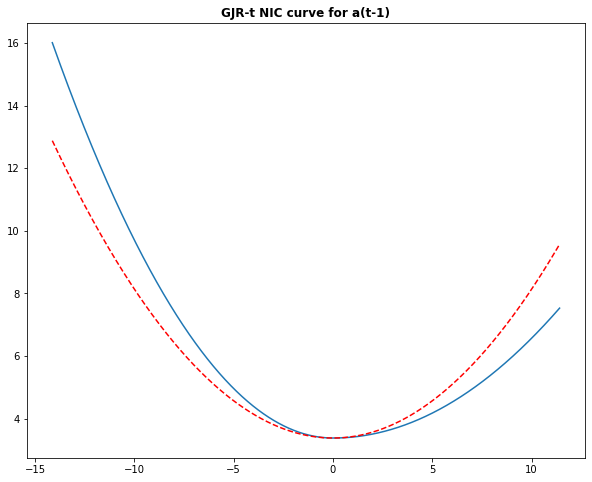


predicted conditional standard deviation values following positive and negative shocks of size 2: 3.6299, 3.5044, 1.0358


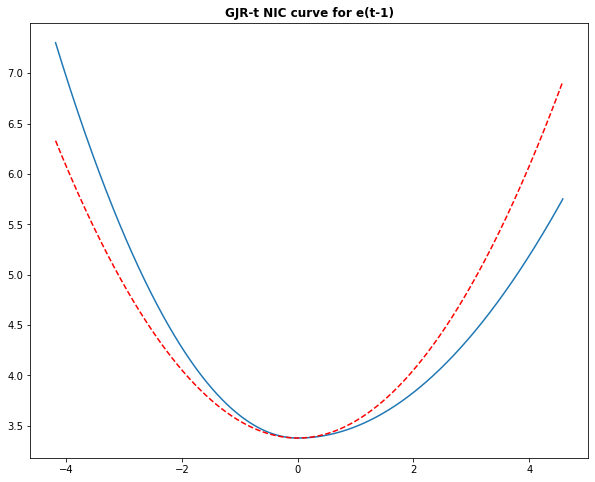

In [58]:
# Get required estimated GJR model coefficients
a1GJt = EstMdl.params['alpha[1]']
b1GJt = EstMdl.params['beta[1]']
g1GJt = EstMdl.params['gamma[1]']
dfGJt = EstMdl.params['nu']
a0GJt = EstMdl.params['omega']



#Calculate values for NIC plot
a = np.arange(min(aGJt), max(aGJt), 0.01) #Plot range
sg = np.var(aGJt) #sample variance of innovations
tmp = g1GJt*(a**2)
sigt = a0GJt + a1GJt * a**2 + b1GJt * sg + np.where(a < 0, g1GJt, 0)*(a**2) #asymmetric curve values
sigt2 = a0GJt + (a1GJt + g1GJt/2) * a**2 + b1GJt * sg #symmetric curve values

fig, axs = plt.subplots(figsize = (10,8))
axs.plot(a, sigt)
axs.plot(a, sigt2, ls = '--', c = 'r')
axs.set_title('GJR-t NIC curve for a(t-1)', weight = 'bold')
plt.show()

#compare predicted conditional standard deviation values following positive and negative shocks of size 2
a = -2;
sigtm2 = a0GJt + a1GJt * a**2 + b1GJt * sg + g1GJt * a**2
a = 2
sigta2 = a0GJt + a1GJt * a**2 + b1GJt * sg
print('\npredicted conditional standard deviation values following positive and negative shocks of size 2: {}, {}, {}'.format(round(sigtm2,4), round(sigta2,4), round(sigtm2/sigta2,4)))

#calculate NIC curve - now plotted against standardised shocks 
eps = aGJt/sigGJt;
e = np.arange(eps.min(), eps.max(), 0.01)
a = np.sqrt(sg) * e
sigt = a0GJt + a1GJt * a**2 + b1GJt * sg + np.where(a < 0, g1GJt, 0)*(a**2);
sigt2 = a0GJt + (a1GJt + g1GJt/2) * a**2 + b1GJt * sg;

#NIC plot for e(t-1)
fig, axs = plt.subplots(figsize = (10,8))
axs.plot(e, sigt)
axs.plot(e, sigt2, ls = '--', c = 'r')
axs.set_title('GJR-t NIC curve for e(t-1)', weight = 'bold')
plt.show()


### Q1(d) Fit two AR(1)-EGARCH(1,0) models: one with Gaussian and one with Student-t errors. What are the fitted models? Draw the NIC from these models.

                          AR - EGARCH Model Results                           
Dep. Variable:              Adj Close   R-squared:                       0.000
Mean Model:                        AR   Adj. R-squared:                 -0.000
Vol Model:                     EGARCH   Log-Likelihood:               -9747.65
Distribution:                  Normal   AIC:                           19507.3
Method:            Maximum Likelihood   BIC:                           19546.4
                                        No. Observations:                 5032
Date:                Tue, May 03 2022   Df Residuals:                     5030
Time:                        11:33:58   Df Model:                            2
                                   Mean Model                                   
                    coef    std err          t      P>|t|       95.0% Conf. Int.
--------------------------------------------------------------------------------
Const             0.0446  2.201e-02      2.028

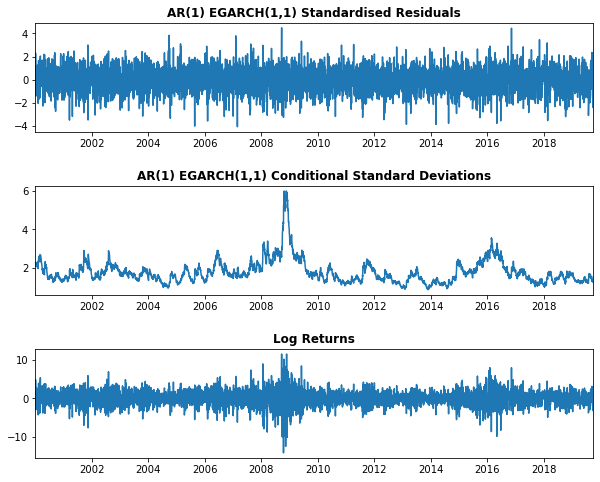


A shock of minus two standard errors gives a 13.995205020330204 percent increase in volatility, compared with the same magnitude positive shock.


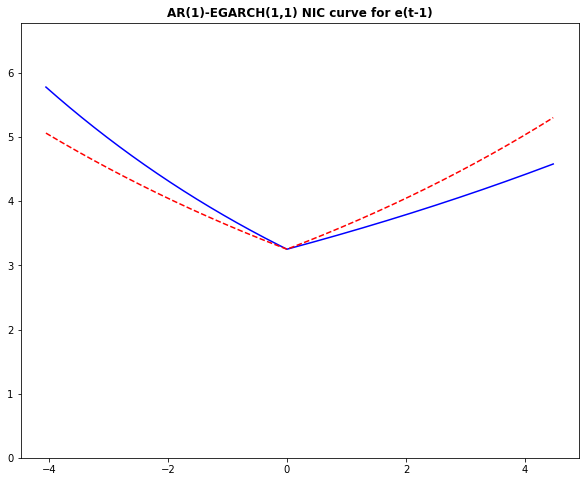

                             AR - EGARCH Model Results                              
Dep. Variable:                    Adj Close   R-squared:                       0.000
Mean Model:                              AR   Adj. R-squared:                 -0.000
Vol Model:                           EGARCH   Log-Likelihood:               -9720.76
Distribution:      Standardized Student's t   AIC:                           19455.5
Method:                  Maximum Likelihood   BIC:                           19501.2
                                              No. Observations:                 5032
Date:                      Tue, May 03 2022   Df Residuals:                     5030
Time:                              11:33:59   Df Model:                            2
                                   Mean Model                                   
                    coef    std err          t      P>|t|       95.0% Conf. Int.
-------------------------------------------------------------------------

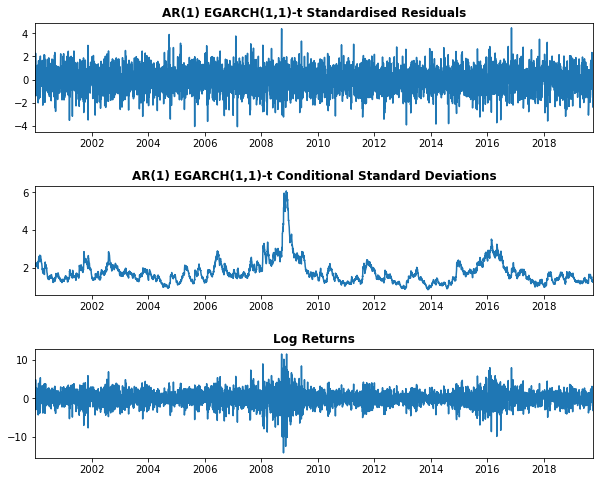


A shock of minus two standard errors gives a 14.774216495400939 percent increase in volatility, compared with the same magnitude positive shock.


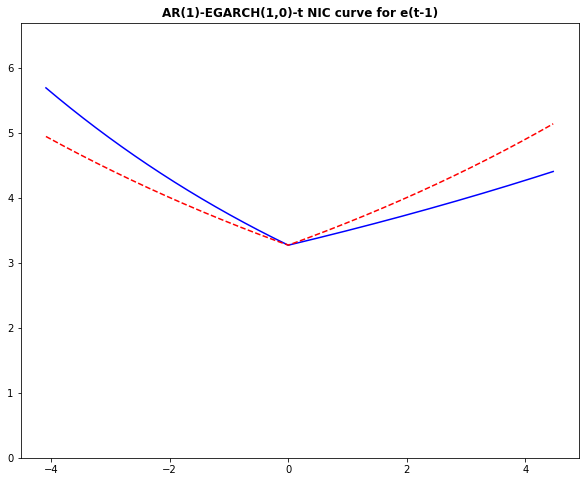

In [62]:
#Fit AR(1)-EGARCH(1,0)-Gaussian model
Mdl = arch_model(y = BHPris, x=None, mean = 'ARX', lags = 1, vol = 'EGARCH', p = 1, o = 1, q = 1)
EstMdl = Mdl.fit(disp='off') #Estimate model, use disp = 'off' to suppress estimation output
seg = EstMdl.conditional_volatility #infer the conditional standard deviations
veg = seg**2 #Conditional variance
aeg = BHPris - EstMdl.params['Const'] #Calculate innovations
eeg= aeg / seg
print(EstMdl.summary())

#Plot the Innoivations, conditional standard deviations and log returns above one another
fig, axs = plt.subplots(3,1, figsize = (10,8))
axs[0].plot(BHPdates[1:nis+1], eeg)
axs[0].set_xlim(BHPdates.min(), BHPdates[nis+1])
axs[0].set_title('AR(1) EGARCH(1,1) Standardised Residuals', weight = 'bold')

axs[1].plot(BHPdates[1:nis+1], seg)
axs[1].set_xlim(BHPdates.min(), BHPdates[nis+1])
axs[1].set_title('AR(1) EGARCH(1,1) Conditional Standard Deviations', weight = 'bold')

axs[2].plot(BHPdates[1:nis+1], BHPris)
axs[2].set_xlim(BHPdates.min(), BHPdates[nis+1])
axs[2].set_title('Log Returns', weight = 'bold')

fig.subplots_adjust(hspace=0.5)
plt.show()

#asymmetry measures for +2 vs -2 standardised shocks
Gama = EstMdl.params['alpha[1]'] #parameter in front of |e(t-1)|
Thet = EstMdl.params['gamma[1]'] #asymmetric parameter, in front of e(t-1)
Asym = np.exp((Thet+Gama)*(-2))/np.exp((Thet-Gama)*2)
print('\nA shock of minus two standard errors gives a {} percent increase in volatility, compared with the same magnitude positive shock.'.format((np.exp(-2*2*Thet)-1)*100))


#NIC curve for AR(1)-EGARCH(1,0)
b1 = EstMdl.params['beta[1]']
a0 = EstMdl.params['omega']

e = np.arange(eeg.min(), eeg.max(), 0.01)
sg = np.var(aeg)
sigte = np.exp(a0 + Gama * (abs(e) - np.sqrt(2/np.pi)) + b1 * np.log(sg) + Thet * e)    
sigt2e = np.exp(a0 + Gama * (abs(e) - np.sqrt(2/np.pi)) + b1 * np.log(sg))

fig, axs = plt.subplots(figsize = (10,8))
axs.plot(e, sigte, c = 'b')
axs.plot(e, sigt2e, c = 'r', ls = '--')
axs.set_title('AR(1)-EGARCH(1,1) NIC curve for e(t-1)', weight = 'bold')
axs.set_ylim(0, sigte.max()+1)
plt.show()

#Fit AR(1)-EGARCH(1,0)-t model
Mdl = arch_model(y = BHPris, x=None, mean = 'ARX', lags = 1, vol = 'EGARCH', p = 1, o = 1, q = 1, dist = 'studentst')
EstMdl = Mdl.fit(disp='off') #Estimate model, use disp = 'off' to suppress estimation output
segt = EstMdl.conditional_volatility #infer the conditional standard deviations
vegt = segt**2 #Conditional variance
aegt = BHPris - EstMdl.params['Const'] #Calculate innovations
eegt = aegt / segt
print(EstMdl.summary())

#Plot the innovations, conditional standard deviations and log returns above one another
#Plot the Innoivations, conditional standard deviations and log returns above one another
fig, axs = plt.subplots(3,1, figsize = (10,8))
axs[0].plot(BHPdates[1:nis+1], eegt)
axs[0].set_xlim(BHPdates.min(), BHPdates[nis+1])
axs[0].set_title('AR(1) EGARCH(1,1)-t Standardised Residuals', weight = 'bold')

axs[1].plot(BHPdates[1:nis+1], segt)
axs[1].set_xlim(BHPdates.min(), BHPdates[nis+1])
axs[1].set_title('AR(1) EGARCH(1,1)-t Conditional Standard Deviations', weight = 'bold')

axs[2].plot(BHPdates[1:nis+1], BHPris)
axs[2].set_xlim(BHPdates.min(), BHPdates[nis+1])
axs[2].set_title('Log Returns', weight = 'bold')

fig.subplots_adjust(hspace=0.5)
plt.show()

#asymmetry measures for +2 vs -2 standardised shocks
Gama = EstMdl.params['alpha[1]'] #parameter in front of |e(t-1)|
Thet = EstMdl.params['gamma[1]'] #asymmetric parameter, in front of e(t-1)
Asym = np.exp((Thet + Gama)*(-2))/np.exp((Thet - Gama)*2)
print('\nA shock of minus two standard errors gives a {} percent increase in volatility, compared with the same magnitude positive shock.'.format((np.exp(-2*2*Thet)-1)*100))


#NIC curve for AR(1)-GARCH(1,1)-t, AR(1)-GJR(1,1)-t, AR(1)-EGARCH(1,0)-t
b1 = EstMdl.params['beta[1]']
a0 = EstMdl.params['omega']
e = np.arange(eegt.min(), eegt.max(), 0.01)
sg = np.var(aegt);
sigte = np.exp(a0 + Gama * (abs(e) - np.sqrt(2/np.pi)) + b1 * np.log(sg) + Thet * e)
sigt2e = np.exp(a0 + Gama * (abs(e) - np.sqrt(2/np.pi)) + b1 * np.log(sg))

fig, axs = plt.subplots(figsize = (10,8))
axs.plot(e, sigte, c = 'b')
axs.plot(e, sigt2e, c = 'r', ls = '--')
axs.set_title('AR(1)-EGARCH(1,0)-t NIC curve for e(t-1)', weight = 'bold')
axs.set_ylim(0, sigte.max()+1)
plt.show()

### Q1(e) Compare the conditional volatility estimates from the models above.

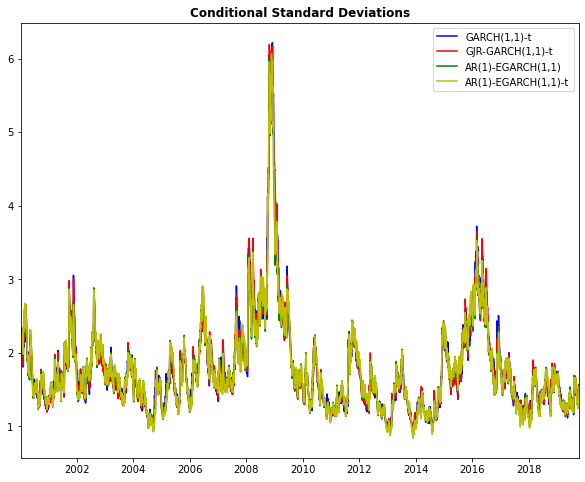

In [63]:
fig, axs = plt.subplots(figsize = (10,8))
axs.plot(BHPdates[1:nis+1], sigGt, c = 'b', label = 'GARCH(1,1)-t')
axs.plot(BHPdates[1:nis+1], sigGJt, c = 'r', label = 'GJR-GARCH(1,1)-t')
axs.plot(BHPdates[1:nis+1], seg, c = 'g', label = 'AR(1)-EGARCH(1,1)')
axs.plot(BHPdates[1:nis+1], segt, c = 'y', label = 'AR(1)-EGARCH(1,1)-t')
axs.set_xlim(BHPdates[1], BHPdates[nis+1])
axs.set_title('Conditional Standard Deviations', weight = 'bold')
axs.legend()
plt.show()

# Q2 Volatility forecasting

### Q2(a) Generate from 1 up to 125-step-ahead forecasts of volatility, for the final 125 daily returns, for the models in Q1. Plot these volatility forecasts and comment/compare.

In [64]:
#Forecast GARCH(1,1)-t model
Mdl = arch_model(y = BHPris, x=None, mean = 'constant', vol = 'GARCH', p = 1, q = 1, dist = 'studentst' )
EstMdl = Mdl.fit(disp='off')
a1g = EstMdl.params['alpha[1]']
b1g = EstMdl.params['beta[1]']
a0g = EstMdl.params['omega']
vGT = EstMdl.forecast( horizon=nf ).variance.values[nis-1,:]
vGT_LR = a0g / ( 1 - a1g - b1g )

#Forecast GJR-GARCH(1,1)-t model
Mdl = arch_model(y = BHPris, x=None, mean = 'constant', vol = 'GARCH', p = 1, q = 1, o = 1, dist = 'studentst')
EstMdl = Mdl.fit(disp='off')
a1gj = EstMdl.params['alpha[1]']
b1gj = EstMdl.params['beta[1]']
a0gj = EstMdl.params['omega']
g = EstMdl.params['gamma[1]']
vGjt = EstMdl.forecast( horizon = nf ).variance.values[nis-1,:]
vGjt_LR = a0gj / (1 - a1gj - b1gj - g/2 )

#Forecast AR(1)-EGARCH model
Mdleg = arch_model(y = BHPris, x=None, mean = 'ARX', lags = 1, vol = 'EGARCH', p = 1, q = 1, o = 1 )
EstMdleg = Mdleg.fit(disp='off')
S0 = EstMdleg.conditional_volatility #infer the conditional standard deviations
V0 = S0**2
A0 = BHPris - EstMdleg.params['Const'] #Calculate innovations
E0 = A0/S0 #Standardized residuals
vAE = EstMdleg.forecast(horizon = nf, method = 'simulation', simulations = 500).variance.values[nis-1,:]
vAE_LR = np.exp(EstMdleg.params['omega']/(1-EstMdleg.params['beta[1]']))

#Forecast AR(1)-EGARCH-t model
Mdlegt = arch_model(y = BHPris, x=None, mean = 'ARX', lags = 1, vol = 'EGARCH', p = 1, q = 1, o = 1, dist = 'studentst')
EstMdlegt = Mdlegt.fit(disp='off')
S0 = EstMdlegt.conditional_volatility #infer the conditional standard deviations
V0 = S0**2
A0 = BHPris - EstMdlegt.params['Const'] #Calculate innovations
E0 = A0/S0 #Standardized residuals
vAEt = EstMdlegt.forecast(horizon = nf, method = 'simulation', simulations = 500).variance.values[nis-1,:]
vAEt_LR = np.exp(EstMdlegt.params['omega']/(1-EstMdlegt.params['beta[1]']))



/home/soraxas/micromamba/envs/qbus/lib/python3.9/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/home/soraxas/micromamba/envs/qbus/lib/python3.9/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(
/home/soraxas/micromamba/envs/qbus/lib/python3.9/site-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change 

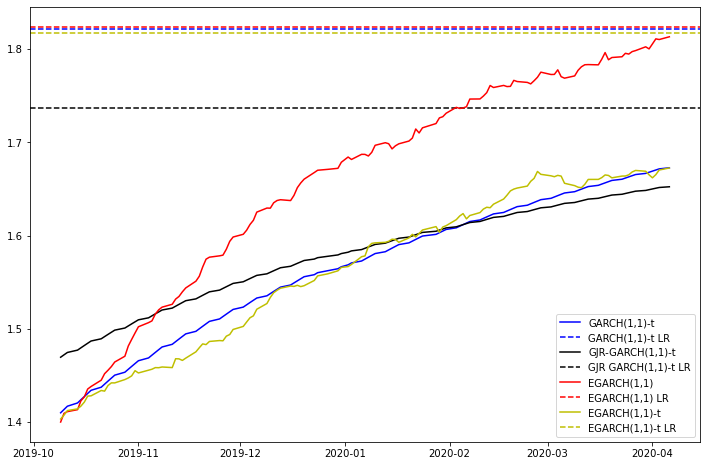

In [65]:
plt.figure( figsize = [ 12, 8 ] )


## GARCH(1,1)-t
plt.plot( BHPdates[nis+1:], np.sqrt(vGT), c = 'b', label = 'GARCH(1,1)-t')
plt.axhline( np.sqrt( vGT_LR ), c = 'b', ls = '--', label = 'GARCH(1,1)-t LR')

## GJR-GARCH(1,1)-t
plt.plot( BHPdates[nis+1:], np.sqrt(vGjt), c = 'k', label = 'GJR-GARCH(1,1)-t') 
plt.axhline( np.sqrt( vGjt_LR ), c = 'k', ls = '--', label = 'GJR GARCH(1,1)-t LR')

## EGARCH(1,1)
plt.plot( BHPdates[nis+1:], np.sqrt(vAE), c = 'r', label = 'EGARCH(1,1)')
plt.axhline( np.sqrt( vAE_LR ), c = 'r', ls = '--', label = 'EGARCH(1,1) LR')

## EGARCH(1,1)-t
plt.plot( BHPdates[nis+1:], np.sqrt(vAEt), c = 'y', label = 'EGARCH(1,1)-t' )
plt.axhline( np.sqrt( vAEt_LR ), c = 'y', ls = '--', label = 'EGARCH(1,1)-t LR' ) 

plt.legend()
plt.show()

### Q2(b) Assess the accuracy of each model's volatility forecasts using volatility proxies 1 to 4. Which models did best overall?

In [69]:
closeC = BHPdata['Close']
highC = BHPdata['High']
lowC = BHPdata['Low']
openC = BHPdata['Open']

## Intraday range
rangC = 100 * np.log( highC / lowC )
rangC[rangC <= 0] = np.mean([0,rangC[rangC > 0].min()])

prox1C = abs( BHPr - BHPr.mean() );
prox2C = np.sqrt(0.3607*(rangC**2))[1:]
prox3C = np.sqrt( 1.107*prox2C**2 + 0.68*((100*np.log(np.divide(openC[1:], closeC[:-1])))**2) )
prox4C = np.sqrt( np.exp(2*np.log(rangC)-0.86+2*0.29**2) )[1:]


## in-sample proxies
prox1Ci = prox1C[:nis]
prox2Ci = prox2C[:nis]
prox3Ci = prox3C[:nis]
prox4Ci = prox4C[:nis]

## forecast-sample proxies
prox1Cf = prox1C[nis:]
prox2Cf = prox2C[nis:]
prox3Cf = prox3C[nis:]
prox4Cf = prox4C[nis:]

#Calculate MSE's for all 4 proxies over forecast-sample for all model forecasts
#np.sqrt(mean((sqrt(vGt)-prox1Cf).^2))
def mse( a, b ):
    return np.sqrt( np.mean( ( a - b )**2 ) )

def mad( a, b ):
    return np.mean( abs( a - b ) )

def compare_all_proxies( a, measure, name ):
    print( name.ljust(16), end = ' ' )
    for i in [ prox1Cf, prox2Cf, prox3Cf, prox4Cf ]:
        print( '%f' % measure( a, i[:len(a)] ), end = ' ' )
    print()

print( "MSE for all 4 proxies over forecast-sample for all model forecasts:" )
compare_all_proxies( np.sqrt(vGT), mse, 'GARCH(1,1)-t' )
compare_all_proxies( np.sqrt(vGjt), mse, 'GJR-GARCH(1,1)-t' )
compare_all_proxies( np.sqrt(vAE), mse, 'EGARCH(1,1)' )
compare_all_proxies( np.sqrt(vAEt), mse, 'EGARCH(1,1)-t' )
print()

print( "MAD for all 4 proxies over forecast-sample for all model forecasts:" )
compare_all_proxies( np.sqrt(vGT), mad, 'GARCH(1,1)-t' )
compare_all_proxies( np.sqrt(vGjt), mad, 'GJR-GARCH(1,1)-t' )
compare_all_proxies( np.sqrt(vAE), mad, 'EGARCH(1,1)' )
compare_all_proxies( np.sqrt(vAEt), mad, 'EGARCH(1,1)-t' )
print()

## Out-of-sample forecasting favours EGARCH(1,1) using MSE, or GARCH(1,1)-t using MAD.

MSE for all 4 proxies over forecast-sample for all model forecasts:
GARCH(1,1)-t     2.178269 1.355044 1.864241 1.551411 
GJR-GARCH(1,1)-t 2.186325 1.370061 1.875684 1.564558 
EGARCH(1,1)      2.168534 1.369643 1.851591 1.548721 
EGARCH(1,1)-t    2.176155 1.352469 1.862386 1.548826 

MAD for all 4 proxies over forecast-sample for all model forecasts:
GARCH(1,1)-t     1.275851 1.087560 1.229894 1.118951 
GJR-GARCH(1,1)-t 1.289157 1.105615 1.247786 1.137353 
EGARCH(1,1)      1.310354 1.136469 1.268597 1.160362 
EGARCH(1,1)-t    1.272927 1.084891 1.227683 1.116139 



### Q2(c) Plot the volatility forecasts together with each proxy, separately. Explain why the results in part (b) occurred.

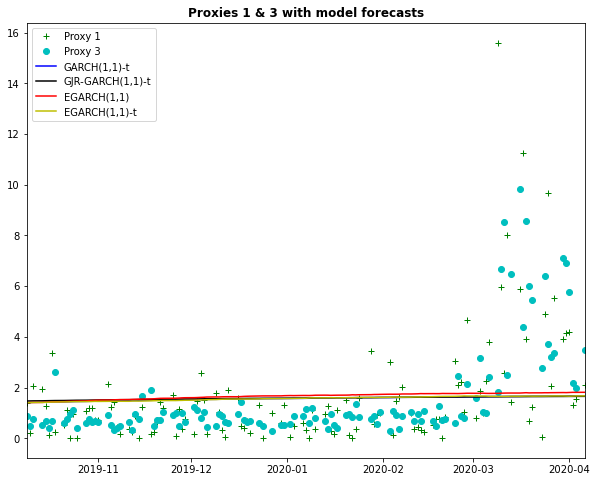

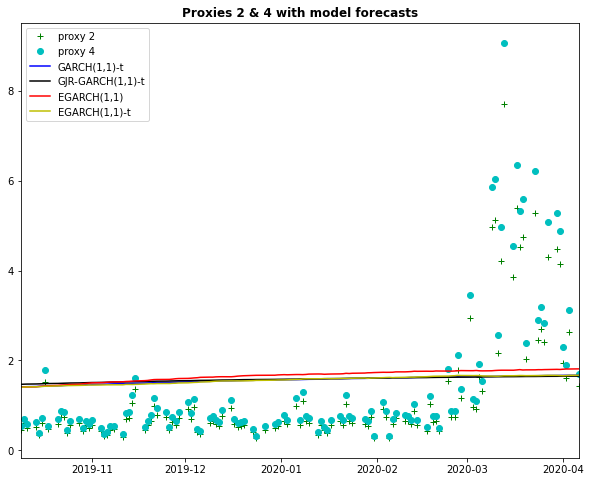

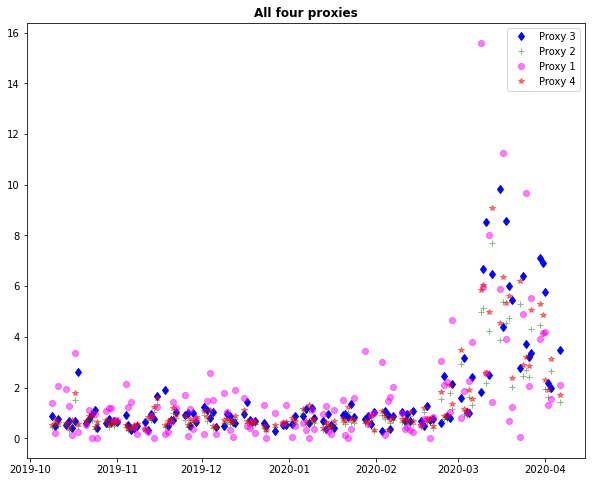

In [72]:
#Plot of proxies 1 and 3
fig, axs = plt.subplots(figsize = (10,8))
axs.plot(BHPdates[nis+1:], prox1Cf, c = 'g', marker = '+', ls = '', label = 'Proxy 1')
axs.plot(BHPdates[nis+1:], prox3Cf[:-1], c = 'c', marker = 'o', ls = '', label = 'Proxy 3')
axs.plot(BHPdates[nis+1:], np.sqrt(vGT),'b', label = 'GARCH(1,1)-t')
axs.plot(BHPdates[nis+1:], np.sqrt(vGjt),'k', label = 'GJR-GARCH(1,1)-t')
axs.plot(BHPdates[nis+1:], np.sqrt(vAE),'r', label = 'EGARCH(1,1)')
axs.plot(BHPdates[nis+1:], np.sqrt(vAEt),'y', label = 'EGARCH(1,1)-t')
axs.set_title('Proxies 1 & 3 with model forecasts', weight = 'bold')
axs.set_xlim(BHPdates[nis+1:].min(), BHPdates[nis+1:].max())
axs.legend()
plt.show()

#Plot of proxies 2 and 4
fig, axs = plt.subplots(figsize = (10,8))
axs.plot(BHPdates[nis+1:], prox2Cf, c = 'g', marker = '+', ls = '', label = 'proxy 2')
axs.plot(BHPdates[nis+1:], prox4Cf, c = 'c', marker = 'o', ls = '', label = 'proxy 4')
axs.plot(BHPdates[nis+1:], np.sqrt(vGT), c = 'b', label = 'GARCH(1,1)-t')
axs.plot(BHPdates[nis+1:], np.sqrt(vGjt), c = 'k', label = 'GJR-GARCH(1,1)-t')
axs.plot(BHPdates[nis+1:], np.sqrt(vAE),'r', label = 'EGARCH(1,1)')
axs.plot(BHPdates[nis+1:], np.sqrt(vAEt),'y', label = 'EGARCH(1,1)-t')
axs.set_title('Proxies 2 & 4 with model forecasts', weight = 'bold')
axs.legend()
axs.set_xlim(BHPdates[nis+1:].min(), BHPdates[nis+1:].max())
plt.show()

fig, axs = plt.subplots(figsize = (10,8))
axs.plot(BHPdates[nis+1:], prox3Cf[:-1], marker = 'd', c = 'b', ls = '', label = 'Proxy 3')
axs.plot(BHPdates[nis+1:], prox2Cf, marker = '+', c = 'g', ls = '', label = 'Proxy 2', alpha = 0.5)
axs.plot(BHPdates[nis+1:], prox1Cf, marker = 'o', c = 'fuchsia', ls = '', label = 'Proxy 1', alpha = 0.5)
axs.plot(BHPdates[nis+1:], prox4Cf, marker = '*', c = 'r', ls = '', label = 'Proxy 4', alpha = 0.5)
axs.legend()
axs.set_title('All four proxies', weight = 'bold')
plt.show()